In [4]:
import os
import shutil

import requests

import time
import numpy as np

import pandas as pd
import polars as pl
import polars.selectors as cs

import duckdb

import pyarrow.parquet as pq

In [5]:
# Cuantos tipos de combustible hay y cuantas filas por cada tipo de combustible
duckdb.sql("""
    SELECT fuel_type, COUNT(fuel_type) as total, ROUND(COUNT(fuel_type)*100/(SELECT COUNT(*) FROM parquet_scan('ignore_data_complete_clean.parquet')), 2) as total_percentage 
    FROM parquet_scan('ignore_data_complete_clean.parquet') 
    GROUP BY fuel_type
    ORDER BY total DESC
""").show(max_rows=100)

┌───────────────┬──────────┬──────────────────┐
│   fuel_type   │  total   │ total_percentage │
│    varchar    │  int64   │      double      │
├───────────────┼──────────┼──────────────────┤
│ petrol        │ 46162947 │            57.66 │
│ diesel        │ 23342285 │            29.16 │
│ electric      │  5191226 │             6.48 │
│ hybrid_petrol │  3465215 │             4.33 │
│ natural_gas   │  1536467 │             1.92 │
│ hybrid_diesel │   190853 │             0.24 │
│ biofuel       │   159867 │              0.2 │
│ hydrogen      │     4257 │             0.01 │
│               │     2809 │              0.0 │
│ petrol-gas    │        1 │              0.0 │
│ NULL          │        0 │              0.0 │
├───────────────┴──────────┴──────────────────┤
│ 11 rows                           3 columns │
└─────────────────────────────────────────────┘



In [3]:
duckdb.sql("""
    SELECT year_of_fabrication, COUNT(*) as total, ROUND(COUNT(*)*100/(SELECT COUNT(*) FROM parquet_scan('ignore_data_complete_clean.parquet')), 2) as total_percentage 
    FROM parquet_scan('ignore_data_complete_clean.parquet') 
    GROUP BY year_of_fabrication
    ORDER BY year_of_fabrication DESC
""").show(max_rows=100)

┌─────────────────────┬──────────┬──────────────────┐
│ year_of_fabrication │  total   │ total_percentage │
│       varchar       │  int64   │      double      │
├─────────────────────┼──────────┼──────────────────┤
│ 2023                │ 10732264 │            13.41 │
│ 2022                │  9383560 │            11.72 │
│ 2021                │  9903434 │            12.37 │
│ 2020                │ 11710019 │            14.63 │
│ 2019                │ 15493586 │            19.35 │
│ 2018                │ 15210440 │             19.0 │
│ 2017                │  4948610 │             6.18 │
│ 2016                │   491239 │             0.61 │
│ 2015                │   432837 │             0.54 │
│ 2014                │   395998 │             0.49 │
│ 2013                │   409207 │             0.51 │
│ 2012                │   345281 │             0.43 │
│ 2011                │   323586 │              0.4 │
│ 2010                │   278539 │             0.35 │
├─────────────────────┴─────

# <p style='text-align: center; text-decoration: underline; color: purple'>Analytics</p>

In [2]:
df = pd.read_csv('df_fit.csv')
df.head()

,ID,Mass_(kg),CO2_emission_(g/km),Fuel_type,Engine_size,Fuel_consumption_(l/100km)
0,123030158,1295.0,132.0,petrol,1.199,5.9
1,50063074,1860.0,193.0,petrol,1.991,8.5
2,480784,1400.0,142.0,petrol,1.498,6.3
3,51827229,1395.0,132.0,petrol,1.499,5.8
4,79992271,1538.0,150.0,petrol,1.598,6.6


In [3]:
print(df.shape)
df.describe()

(2500000, 6)


,ID,Mass_(kg),CO2_emission_(g/km),Engine_size,Fuel_consumption_(l/100km)
count,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06,2.500000e+06
mean,8.886306e+07,1.517236e+03,1.519244e+02,1.619653e+00,6.491588e+00
std,3.504267e+07,2.978514e+02,3.084611e+01,5.958708e-01,1.237810e+00
min,1.000000e+00,9.150000e+02,1.020000e+02,8.750000e-01,5.500000e+00
25%,5.656370e+07,1.295000e+03,1.320000e+02,1.199000e+00,5.800000e+00
50%,8.168524e+07,1.440000e+03,1.430000e+02,1.498000e+00,6.100000e+00
75%,1.241765e+08,1.670000e+03,1.580000e+02,1.969000e+00,6.700000e+00
max,1.496951e+08,2.996000e+03,5.720000e+02,7.993000e+00,2.520000e+01


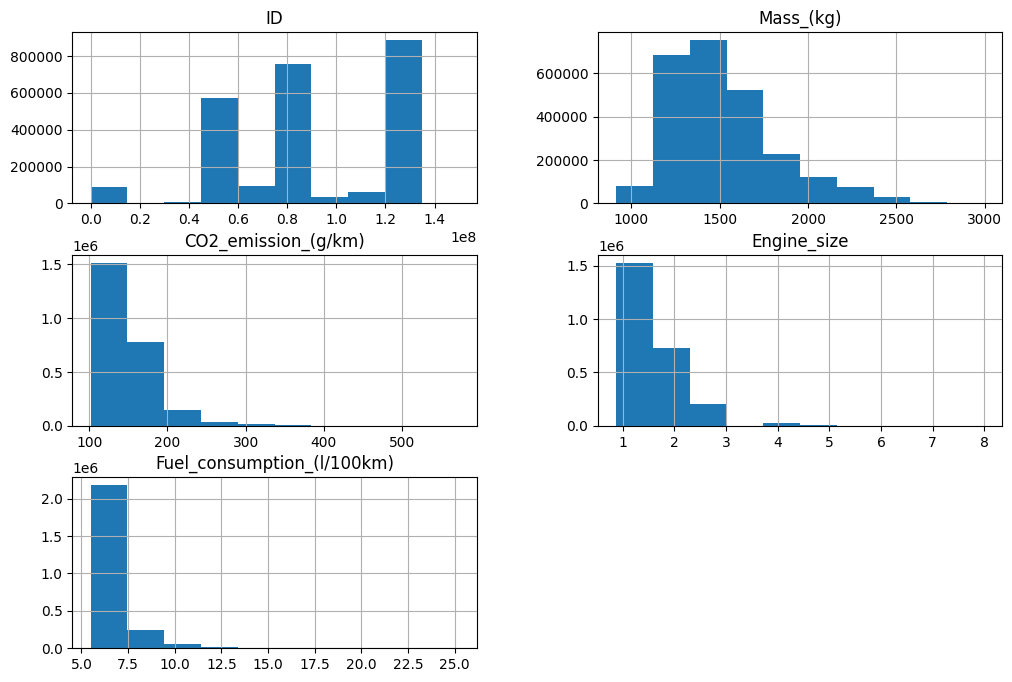

In [4]:
df.hist(figsize=(12, 8))
plt.show()

In [5]:
df1 = df[(df['Mass_(kg)'] >= 900) & (df['Mass_(kg)'] <= 3000)]
df1.head()

,ID,Mass_(kg),CO2_emission_(g/km),Fuel_type,Engine_size,Fuel_consumption_(l/100km)
0,123030158,1295.0,132.0,petrol,1.199,5.9
1,50063074,1860.0,193.0,petrol,1.991,8.5
2,480784,1400.0,142.0,petrol,1.498,6.3
3,51827229,1395.0,132.0,petrol,1.499,5.8
4,79992271,1538.0,150.0,petrol,1.598,6.6


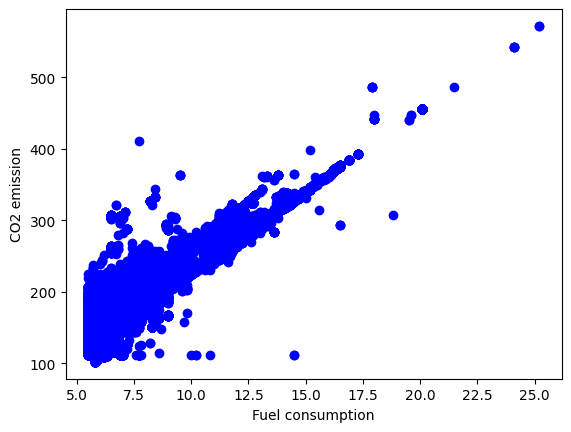

In [6]:
plt.scatter(df['Fuel_consumption_(l/100km)'], df['CO2_emission_(g/km)'], color='blue')
plt.xlabel('Fuel consumption')
plt.ylabel('CO2 emission')
plt.show()

In [7]:
df.sort_values('CO2_emission_(g/km)')

,ID,Mass_(kg),CO2_emission_(g/km),Fuel_type,Engine_size,Fuel_consumption_(l/100km)
398823,399582,1300.0,102.0,petrol,1.498,5.8
266211,905033,1300.0,102.0,petrol,1.498,5.8
1534958,860109,1300.0,102.0,petrol,1.498,5.8
1660452,80416,1300.0,102.0,petrol,1.498,5.8
204942,665194,1300.0,102.0,petrol,1.498,5.8
...,...,...,...,...,...,...
390207,130551872,1435.0,543.0,petrol,6.499,24.1
1541271,79948996,1435.0,543.0,petrol,6.499,24.1
799010,79949000,1435.0,543.0,petrol,6.499,24.1
1407527,51966572,2070.0,572.0,petrol,7.993,25.2


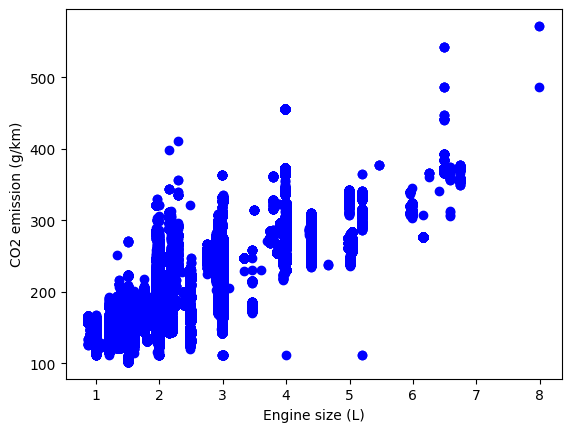

In [11]:
plt.scatter(df['Engine_size'], df['CO2_emission_(g/km)'], color='blue')
plt.xlabel('Engine size (L)')
plt.ylabel('CO2 emission (g/km)')
plt.show()

---

## Modelo de regresion lineal

### Entrenamiento

In [9]:
msk = np.random.rand(len(df)) < 0.8 #msk = mask. Lista de len(df) numeros aleatorios entre el 0 y 1. aproximadamente el 80% del conjunto (<0.8)
train = df[msk]
test = df[~msk]

In [ ]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Engine_size']])
train_y = np.asanyarray(train[['CO2_emission_(g/km)']])
regr.fit(train_x, train_y)

#Coeficientes
print('Pendiente:', regr.coef_)
print('Interseccion', regr.intercept_)

Pendiente: [[39.83336065]]
Interseccion [87.41913548]


##### Graficamos el resultado

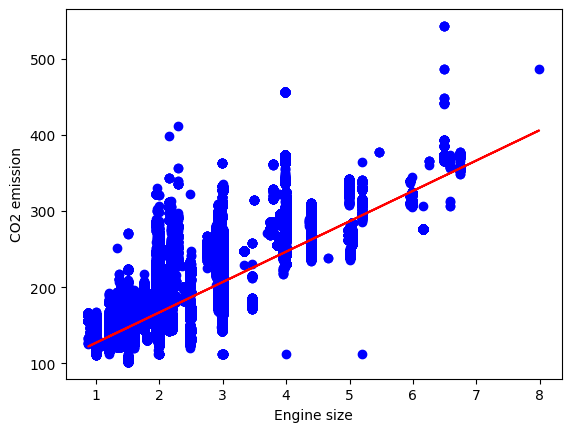

In [14]:
plt.scatter(train['Engine_size'], train['CO2_emission_(g/km)'], color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel('Engine size')
plt.ylabel('CO2 emission')
plt.show()

### Testeo

In [15]:
from sklearn.metrics import r2_score, mean_squared_error

test_x = np.asanyarray(test[['Engine_size']])
test_y = np.asanyarray(test[['CO2_emission_(g/km)']])
test_y_ = regr.predict(test_x)

print('Error medio absoluto: %.2f' % np.mean(np.absolute(test_y_ - test_y)))
print('Residual de la suma de los cuadrados (MSE): %0.2f' % np.mean((test_y_ - test_y)**2))
print('R2-score: %0.2f' % r2_score(test_y, test_y_))

Error medio absoluto: 13.46
Residual de la suma de los cuadrados (MSE): 387.63
R2-score: 0.59


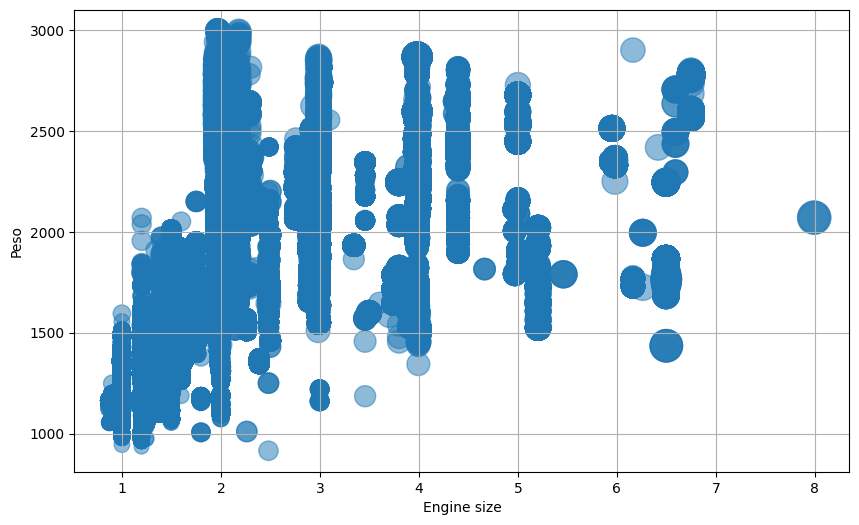

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Engine_size'], df['Mass_(kg)'], s=df['CO2_emission_(g/km)'], alpha=0.5)
plt.xlabel('Engine size')
plt.ylabel('Peso')
plt.grid(True)
plt.show()

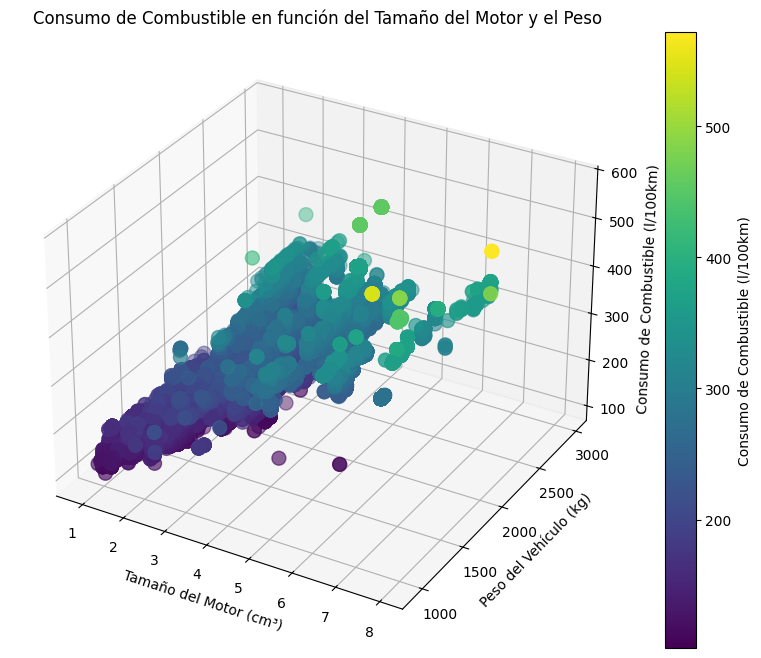

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['Engine_size']
y = df['Mass_(kg)']
z = df['CO2_emission_(g/km)']

scatter = ax.scatter(x, y, z, c=z, cmap='viridis', s=100)
ax.set_xlabel('Tamaño del Motor (cm³)')
ax.set_ylabel('Peso del Vehículo (kg)')
ax.set_zlabel('Consumo de Combustible (l/100km)')
ax.set_title('Consumo de Combustible en función del Tamaño del Motor y el Peso')

plt.colorbar(scatter, label='Consumo de Combustible (l/100km)')

plt.show()

---
---
---
---
---

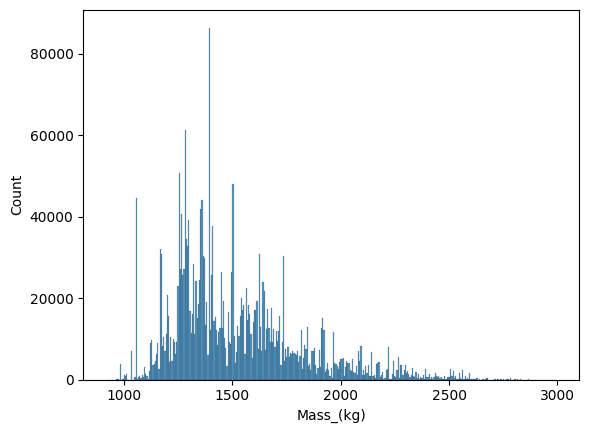

In [18]:
sns.histplot(df['Mass_(kg)'])
plt.show()

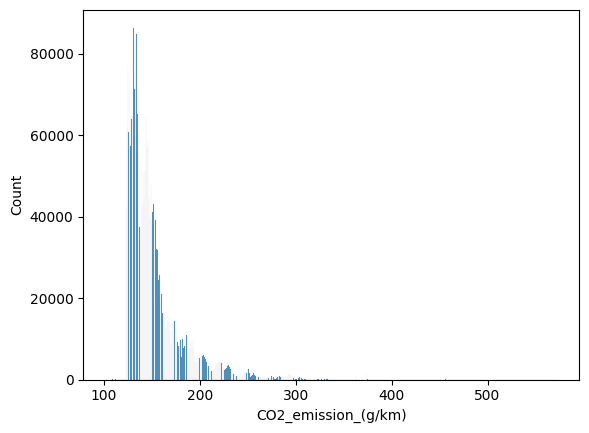

In [19]:
sns.histplot(df['CO2_emission_(g/km)'])
plt.show()

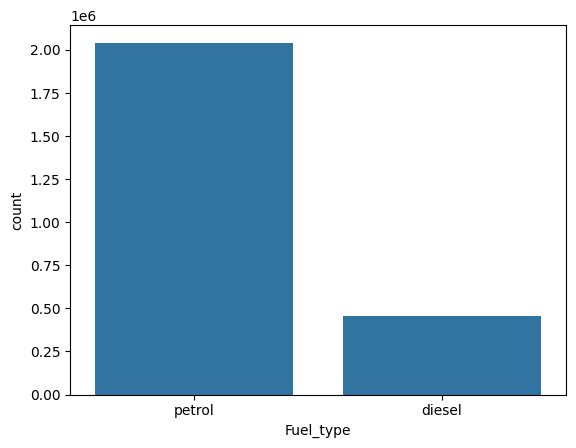

In [20]:
sns.countplot(x='Fuel_type', data=df)
plt.show()

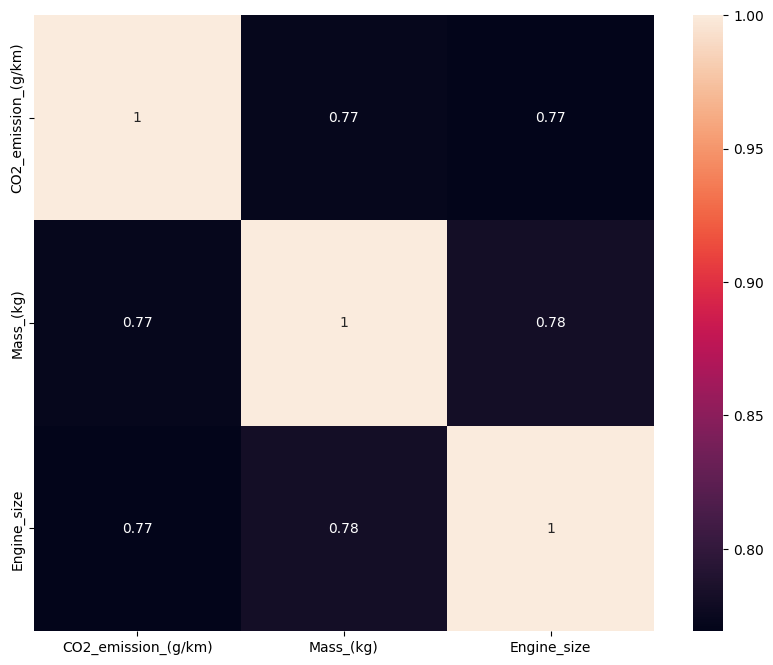

In [21]:
# Calcular la matriz de correlación
correlation_matrix = df[['CO2_emission_(g/km)', 'Mass_(kg)', 'Engine_size']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [22]:
df2 = pd.get_dummies(df, columns=['Fuel_type'], drop_first=True)

from sklearn.model_selection import train_test_split
x = df2.drop('CO2_emission_(g/km)', axis=1)
y = df2['CO2_emission_(g/km)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  19.39746918055264
R2 Score:  0.9795919692413497


In [24]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  1.6011463816666667
R2 Score:  0.9983154377356137
